# Intensive Computation 2021/2022 Project - Reversible Carry Select Adder implementation with qiskit 

In [2]:
from qiskit import QuantumRegister, ClassicalRegister, AncillaRegister, QuantumCircuit, assemble, Aer, transpile
from qiskit.providers.aer import AerSimulator, UnitarySimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [3]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.20.2', 'qiskit-aer': '0.10.4', 'qiskit-ignis': '0.7.1', 'qiskit-ibmq-provider': '0.19.1', 'qiskit-aqua': None, 'qiskit': '0.36.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

## Ausiliary Gates Implementations
* controlled SXdgGate
* Peres gate
* FA

In [4]:
"""
Controlled Version of SXdgGate. 
"""

from qiskit.circuit.library import SXdgGate

csxdg = SXdgGate().control(1)

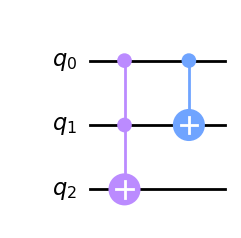

In [5]:
"""
Peres Gate implementation.

Parameters
----------
A
B
C

Returns
-------
P = A
Q = A XOR B
R = AB XOR C
"""

#qc_peres = QuantumCircuit(3)
#qc_peres.append(csxdg, qargs=[0,2])
#qc_peres.append(csxdg, qargs=[1,2])
#qc_peres.cnot(0,1)
#qc_peres.csx(1,2)

qc_peres = QuantumCircuit(3)
qc_peres.ccx(0,1,2)
qc_peres.cx(0,1)

PeresGate = qc_peres.to_gate(label="PG")

qc_peres.draw(output='mpl')


In [6]:
def generate_binary_strings(bit_count: int) -> list:
    """Helper function to generate all possible binary strings of a given length.
    
    Parameters
    ----------
    bit_count : int 

    Returns
    -------
    list of strings
    """


    binary_strings = []
    def genbin(n, bs=''):
        if len(bs) == n:
            binary_strings.append(bs)
        else:
            genbin(n, bs + '0')
            genbin(n, bs + '1')


    genbin(bit_count)
    return binary_strings

def simulate_circuit(inpts: list, circuit_generator) -> QuantumCircuit:
    """Helper function to simulate Peres and FA circuits on a list of inputs.
    
    Parameters
    ----------
    inpts : list of 3 bits string represent a,b,c

    Prints
    -------
    the result of the simulation for every input

    Returns
    -------
    the instance of the QuantumCircuit genereated by circuit_generator, with the last input used
    """

    
    for inp in inpts:
    # create the circuit
        qc = circuit_generator(*inp)
        
        # simulate it
        backend = AerSimulator() 
        qc_compiled = transpile(qc, backend)
        job_sim = backend.run(qc_compiled, shots=1, memory=True)
        output = job_sim.result().get_memory()[0]

        # print the result
        print("in: {} \t out: {}".format(inp, output))
    
    return qc




in: 000 	 out: 000
in: 001 	 out: 001
in: 010 	 out: 010
in: 011 	 out: 011
in: 100 	 out: 110
in: 101 	 out: 111
in: 110 	 out: 101
in: 111 	 out: 100


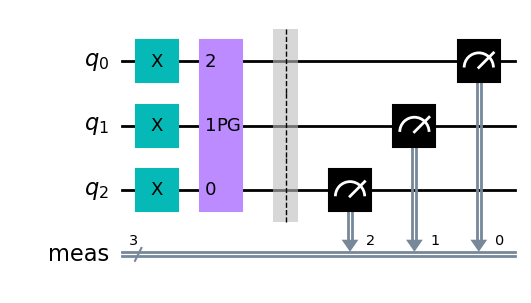

In [7]:


def circuit_peres(a: str, b: str, c:str) -> QuantumCircuit:
    inputs = [a,b,c]
    qc = QuantumCircuit(3)
    
    # encode the input
    for i in range(len(inputs)):
        if inputs[i] == '1':
            qc.x(i)

    # perform the operation
    qc.append(PeresGate, qargs=[0,1,2])

    # measure the output
    qc.measure_all(inplace=True) # save space
    qc = qc.reverse_bits() # measure_all() follows the BE order -> revert it

    return qc

inputs = generate_binary_strings(3)

c_peres = simulate_circuit(inputs, circuit_peres)

# plot the circuit (note: the input is 111, the last one)
c_peres.draw(output='mpl')

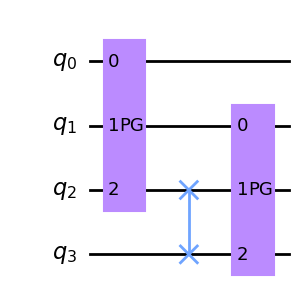

In [8]:
"""
FA implementation using Peres Gates.

Parameters
----------
A
B
0 - ancilla
C_in

Returns
-------
P' = A
P'' = A XOR B
Sum
C_out
"""

qc_fa = QuantumCircuit(4)
qc_fa.append(PeresGate, qargs=[0,1,2])
qc_fa.swap(2,3)
qc_fa.append(PeresGate, qargs=[1,2,3]) # we could invert 3,2 and save a swap gate, but the resulting circuit is messier

# create a FA "Gate"
FA = qc_fa.to_gate(label="FA")

# draw the circuit
qc_fa.draw(output='mpl')

    abc 	      cs
in: 000 	 out: 00
in: 001 	 out: 01
in: 010 	 out: 01
in: 011 	 out: 10
in: 100 	 out: 01
in: 101 	 out: 10
in: 110 	 out: 10
in: 111 	 out: 11


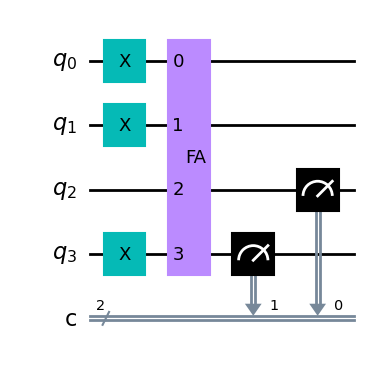

In [9]:
def circuit_FA(a:str, b:str, c:str) -> QuantumCircuit:
    ancilla = '0'
    inputs = [a, b, ancilla, c]
    qc = QuantumCircuit(4,2)
    
    # encode the input
    for i in range(len(inputs)):
        if inputs[i] == '1':
            qc.x(i)
    
    # perform the operation
    qc.append(FA, qargs=[0,1,2,3])

    # measure the output
    qc.measure(3,1) # carry -> MSB
    qc.measure(2,0) # sum   -> LSB

    return qc

inputs = generate_binary_strings(3)

print("    abc \t      cs")

c_FA = simulate_circuit(inputs, circuit_FA)

# plot the circuit (note: the input is 111, the last one)
c_FA.draw(output='mpl')

## RCSA - design 1

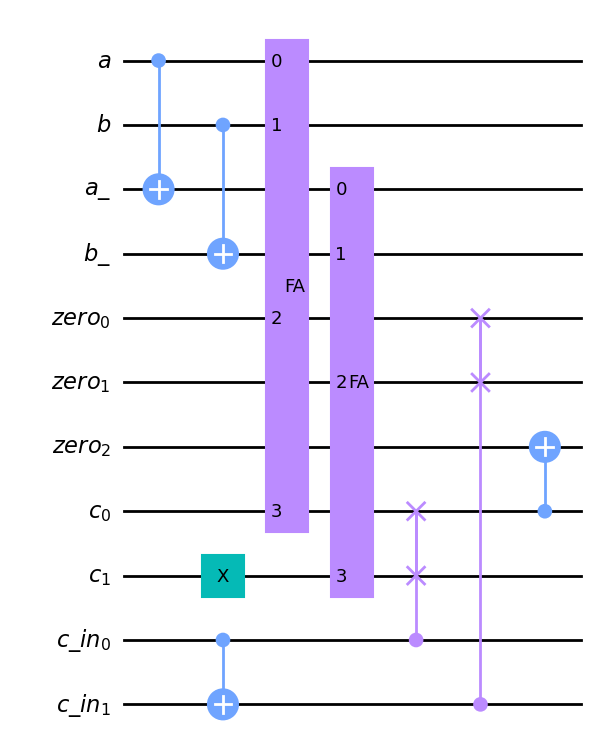

In [10]:
"""
8-bit RCSA 'design1' implementation, with block size = 1 (as seen in paper).

Parameters
----------
Quantum Registers:
    OPERANDS
    a: first operand
    b: second operand
    a_: copy of first operand
    b_: copy of second operand
    
    CARRIES
    c_in: carry_in
        c_in: input carry
        c_in_: copy of input carry

Ancilla Registers:
    CARRIES
    c: RFA carries
        c_0: carry of the first RFA
        c_1: carry of the second RFA
    
    ANCILLAE
    zero:
        RFA: ancilla of the first RFA
        RFA_: ancilla of the second RFA
        CNOT: ancilla of the CNOT "buffer"


Returns
-------



"""

a = QuantumRegister(1, name='a')
b = QuantumRegister(1, name='b')
a_ = QuantumRegister(1, name='a_')
b_ = QuantumRegister(1, name='b_')
c_in = QuantumRegister(2, name='c_in')
c = AncillaRegister(2, name='c')
zero = AncillaRegister(3, name='zero')

qc_rcsa = QuantumCircuit(a, b, a_, b_, zero, c, c_in)

# encode the input
qc_rcsa.cx(a, a_)
qc_rcsa.cx(b, b_)
qc_rcsa.x(c[1])
qc_rcsa.cx(c_in[0], c_in[1])


# perform the operations
qc_rcsa.append(FA, qargs=[a,b, zero[0], c[0]])
qc_rcsa.append(FA, qargs=[a_,b_, zero[1], c[1]])
qc_rcsa.cswap(control_qubit=c_in[0], target_qubit1 = c[0], target_qubit2 = c[1]) # s
qc_rcsa.cswap(c_in[1], zero[0], zero[1]) # c_out
qc_rcsa.cx(c[0], zero[2])


qc_rcsa.draw(output="mpl")



In [11]:
from typing import List, Union

def circuit_RCSA(n: int, a_inp:str, b_inp:str, c_inp:str) -> QuantumCircuit:
    """Implements a circuit for an n-bit RCSA.


    Parameters
    ----------


    Returns
    -------
    """

    name = "RCSA design 1"

    a_inp = a_inp[::-1] # read from LSB to MSB
    b_inp = b_inp[::-1]

    a = QuantumRegister(n, name='a')
    b = QuantumRegister(n, name='b')
    a_ = QuantumRegister(n, name='a_')
    b_ = QuantumRegister(n, name='b_')
    zero = AncillaRegister(n, name='zero')
    zero_ = AncillaRegister(n, name='zero_')
    c0 = AncillaRegister(n, name='c0')
    c1 = AncillaRegister(n, name='c1')
    c_in = QuantumRegister(2, name='c_in')
    zero_BUF = AncillaRegister(n-1, name='zero_BUF')

    result = ClassicalRegister(n+1, name='result') # +1 to consider the carry

    qc_rcsa = QuantumCircuit(a, b, a_, b_, zero, zero_, c0, c1, c_in,  zero_BUF, result)

    # encode the input
    if c_inp == '1':
        qc_rcsa.x(c_in[0])

    for i in range(n):
        if a_inp[i] == '1':
            qc_rcsa.x(a[i])
        if b_inp[i] == '1':
            qc_rcsa.x(b[i])
        qc_rcsa.reset(a_[i])
        qc_rcsa.reset(b_[i])
        qc_rcsa.cx(a[i], a_[i]) # copy a -> a_
        qc_rcsa.cx(b[i], b_[i]) # copy b -> b_
        qc_rcsa.reset(c0[i])     # set c0 = 0
        qc_rcsa.reset(c1[i])
        qc_rcsa.x(c1[i])        # set c1 = 1
        qc_rcsa.reset(zero[i])
        qc_rcsa.reset(zero_[i])
    qc_rcsa.reset(c_in[1])
    qc_rcsa.cx(c_in[0], c_in[1]) # copy c_in[0] -> c_in[1] 


    # perform the operations
    for i in range(n):
        qc_rcsa.append(FA, qargs=[a[i],b[i], zero[i], c0[i]])
        qc_rcsa.append(FA, qargs=[a_[i],b_[i], zero_[i], c1[i]])
        if i == 0:
            qc_rcsa.cswap(c_in[1], zero[i], zero_[i])   # c_out
            qc_rcsa.cswap(c_in[0], c0[i], c1[i])        # s
        else:
            qc_rcsa.cswap(c0[i-1], zero[i], zero_[i])   # c_out    # it may be: c0[i-1], zero[i], zero_[i] 
            qc_rcsa.cswap(zero_BUF[i-1], c0[i], c1[i])  # s        # it may be: c[i-1], zero[i], zero_[i] 
        
        #qc_rcsa.measure(c0[i], result[i]) # measure the s
        qc_rcsa.measure(zero[i], result[i])

        if i < (n-1):
            qc_rcsa.cx(c0[i], zero_BUF[i])
        else:
            qc_rcsa.measure(c0[i], result[i+1]) 

  
    return qc_rcsa

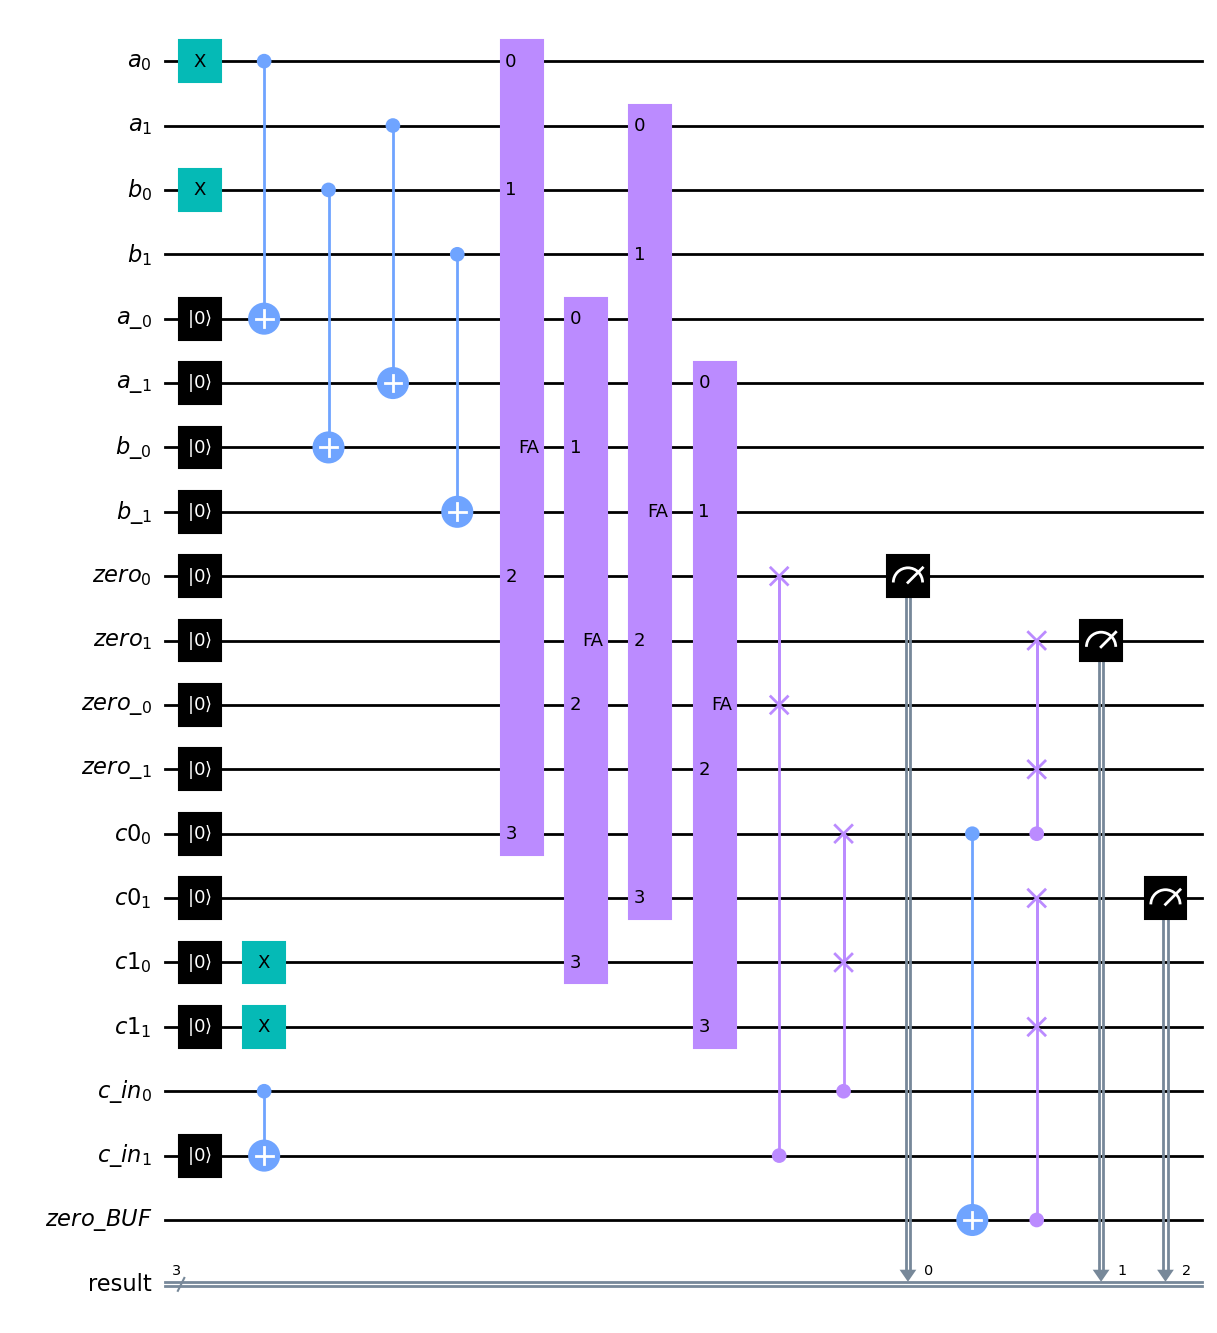

In [12]:
RCSA = circuit_RCSA(2, '01', '01', '0')
RCSA.draw(output="mpl")

In [487]:
import random
lista = ["00", "01", "10", "11"]
random.sample(lista, 3)

inputs = generate_binary_strings(8)
print(len(inputs) * 0.1)

25.6


In [497]:
# check correctness

def check_correctness(n: int, carry_in: str, circuitGenerator, getRandomInputs=False):
    inputs = generate_binary_strings(n)
    print(inputs)
    if getRandomInputs:
        inputs = random.sample(inputs, 5)
    
    print(len(inputs))

    print("abc \t c s\n-------------")
    for a in range(len(inputs)):
        for b in range(len(inputs)):
            qc = circuitGenerator(n, inputs[a], inputs[b], carry_in)
            
            usim = Aer.get_backend('unitary_simulator')
            transpiled = transpile(qc, backend=usim)
            backend = Aer.get_backend('aer_simulator')
            job = backend.run(transpiled, shots=1, memory=True)
            result_sim = job.result().get_memory()[0]
            
            #backend = AerSimulator() #Aer.get_backend('aer_simulator')
            # transpile the circuit
            #qc_compiled = transpile(qc, backend)
            # execute the circuit
            #job_sim = backend.run(qc_compiled, shots=1, memory=True)
            #result_sim = job_sim.result().get_memory()[0]
            
            print("{}+{}+{} \t {} {}".format(inputs[a], inputs[b], int(carry_in), result_sim[0], result_sim[1:]))
                        

In [23]:
check_correctness(2,'0', circuit_RCSA)

['00', '01', '10', '11']
abc 	 c s
-------------
00+00+0 	 0 00
00+01+0 	 0 01
00+10+0 	 0 10
00+11+0 	 0 11
01+00+0 	 0 01
01+01+0 	 0 10
01+10+0 	 0 11
01+11+0 	 1 00
10+00+0 	 0 10
10+01+0 	 0 11
10+10+0 	 1 00
10+11+0 	 1 01
11+00+0 	 0 11
11+01+0 	 1 00
11+10+0 	 1 01
11+11+0 	 1 10


In [24]:
check_correctness(2,'1', circuit_RCSA)

['00', '01', '10', '11']
abc 	 c s
-------------
00+00+1 	 0 01
00+01+1 	 0 10
00+10+1 	 0 11
00+11+1 	 1 00
01+00+1 	 0 10
01+01+1 	 0 11
01+10+1 	 1 00
01+11+1 	 1 01
10+00+1 	 0 11
10+01+1 	 1 00
10+10+1 	 1 01
10+11+1 	 1 10
11+00+1 	 1 00
11+01+1 	 1 01
11+10+1 	 1 10
11+11+1 	 1 11


In [83]:
import pprint as pp

In [156]:
def circuit_analysis(n, circuit_generator, name="CIRCUIT NAME", Transpile=False, optLevel=None, displayCircuit=False):
    """Measure the depth, the width and the count_ops of a circuit, whose input has lenght n"""
    
    inpt = "0" * n
    c_in = "0"
    qc = circuit_generator(n, inpt, inpt, c_in)

    
    if not Transpile:    
        print("\n{}-bit {} analysis:\n-------------------".format(n, name))
        print("depth: {}\nwidth:{}".format(qc.depth(), qc.width()))
        pp.pprint({'count_ops': dict(qc.count_ops())} )
        #tmp = dict(qc.count_ops())    
        #print("count_ops: {}".format(pp.pprint(tmp, width=1)))
        
        #pp.pprint("count_ops:{}".format(tmp), width = 1)
        
        if displayCircuit:
            qc.draw(output="mpl")

    else:
        print("{}-bit {}-Transpiled analysis:\n-------------------".format(n, name))
        backend = Aer.get_backend('unitary_simulator') #.get_backend('aer_simulator') 
        qc_compiled = transpile(qc, backend, optimization_level=optLevel)
        print("depth: {}\nwidth:{}".format(qc_compiled.depth(), qc_compiled.width()))
        pp.pprint({'count_ops': dict(qc_compiled.count_ops())} )
        if displayCircuit:
            qc_compiled.draw(output="mpl")


    
     


In [164]:
n = 4
circuit_analysis(n, circuit_RCSA, name = "RCSA - design 1", Transpile=False, displayCircuit=False)


4-bit RCSA - design 1 analysis:
-------------------
depth: 11
width:42
{'count_ops': {'circuit-229': 8,
               'cswap': 8,
               'cx': 12,
               'measure': 5,
               'reset': 25,
               'x': 4}}


In [165]:
optLevel = 0 # NO OPTIMIZATION
circuit_analysis(n, circuit_RCSA, name = "RCSA - design 1", Transpile=True, optLevel=optLevel, displayCircuit=False)

4-bit RCSA - design 1-Transpiled analysis:
-------------------
depth: 13
width:42
{'count_ops': {'ccx': 16,
               'cswap': 8,
               'cx': 28,
               'measure': 5,
               'reset': 25,
               'swap': 8,
               'x': 4}}


In [166]:
optLevel = 2
circuit_analysis(n, circuit_RCSA, name = "RCSA - design 1", Transpile=True, optLevel=optLevel, displayCircuit=False)

4-bit RCSA - design 1-Transpiled analysis:
-------------------
depth: 12
width:42
{'count_ops': {'ccx': 16,
               'cswap': 8,
               'cx': 28,
               'measure': 5,
               'swap': 8,
               'x': 4}}


In [167]:
optLevel = 3
circuit_analysis(n, circuit_RCSA, name = "RCSA - design 1", Transpile=True, optLevel=optLevel, displayCircuit=False)

4-bit RCSA - design 1-Transpiled analysis:
-------------------
depth: 60
width:42
{'count_ops': {'cx': 124,
               'h': 16,
               'measure': 5,
               'swap': 8,
               't': 56,
               'tdg': 48,
               'u2': 24,
               'unitary': 24,
               'x': 4}}


> nb: all the circuit properties have been computed considering the gates for all the 3 main phases:
1. *input encoding*
2. *operations*
3. *measurements*

By following the diagram for the RCSA - design 1 - as showed in [1], we can observe that, whatever the lenght of the operands is, the resulting circuit with the custom gates (*i.e.* Peres, RFA) has always the **shortest critical path** a.k.a *depth*. But beware: it is apparent: we can notice indeed that the transpiled circuit with **no optimization** has a depth of 13, higher than the circuit with the custom gates.

A 'medium' level of optimization let us get rid of some unecessary instructions, such as the `reset` at the very beginning of the circuit: as a result we could shorten the depth of the original circuit by 1.

A 'high' level of optimization comes at the cost of a deeper circuit, but we gain in number of 1 x 1 gates, whose **quantum cost** is 0:

* optLevel = 2:
    - `ccx`: 16 -> 16 * 5 = 80
    - `cswap`: 8 -> 8 * 5 = 40 
    - `cx`: 28 -> 28 * 2 = 56
    - `measure`: 5 -> 5 * 0 = 0
    - `swap`: 8 -> 8 * 1 = 8
    - `x`: 4 -> 4 * 0 = 0
    TOT: 80 + 40 + 56 + 8 = 184

* optLevel = 3:
    - `cx`: 124 -> 124 * 1 = 124
    - `h`: 16 -> 16 * 0 = 0
    - `measure`: 5 -> 5 * 0 = 0
    - `swap`: 8 -> 8 * 1 = 8
    - `t`: 56 -> 56 * 0 = 0
    - `tdg`: 48 -> 56 * 0 = 0
    - `u2`: 24 -> 24 * 0 = 0
    - `unitary`: 24 -> 24 * 0 = 0
    - `x`: 4 -> 4 * 0 = 0
    TOT: 124 + 8 = 132



## RCSA - design 1 - v1: 4 submodules of 2 bits RFA adder

In [438]:
from math import floor
def circuit_RCSA_v1_old(n: int, a_inp:str, b_inp:str, c_inp:str) -> QuantumCircuit:
    """Implements a circuit for an n-bit RCSA.

    It works, but there's redundancy in the code. There's a version with less lines,
    but the readability is not as good as this version.

    Parameters
    ----------


    Returns
    -------
    """

    name = "RCSA design 1"

    a_inp = a_inp[::-1] # read from LSB to MSB
    b_inp = b_inp[::-1]


    qc_rcsa = QuantumCircuit()


    a = QuantumRegister(n, name='a')
    b = QuantumRegister(n, name='b')
    a_ = QuantumRegister(n, name='a_')
    b_ = QuantumRegister(n, name='b_')

    c0 = QuantumRegister(n, name='c0') # THEY CAN BE HALVED, since the second couple of RFA do not take in input a fixed 0/1
    c1 = QuantumRegister(n, name='c1') # THEY CAN BE HALVED, ...

    zero = QuantumRegister(n, name='zero')   # can be renamed zero0, as in c0 and c1
    zero_ = QuantumRegister(n, name='zero_') # can be renamed zero1
    
    c_in = QuantumRegister(3, name='c_in')   # they can probably be reduced to just 1 qubit

    zero_BUF = QuantumRegister(n/2, name='zero_BUF') # n is guaranteed to be even

    result = ClassicalRegister(n+1, name='result')

    qc_rcsa = QuantumCircuit(a, b, a_, b_, zero, zero_, c0, c1, c_in, zero_BUF, result)

    # encode the input
    if c_inp == '1':
        qc_rcsa.x(c_in[0])
    
    qc_rcsa.reset(c_in[1])
    qc_rcsa.reset(c_in[2])

    qc_rcsa.cx(c_in[0], c_in[1]) # copy the c_in
    qc_rcsa.cx(c_in[0], c_in[2]) # copy the c_in

    for i in range(n):
        if a_inp[i] == '1':
            qc_rcsa.x(a[i])
        if b_inp[i] == '1':
            qc_rcsa.x(b[i])
        qc_rcsa.reset(a_[i])
        qc_rcsa.reset(b_[i])
        qc_rcsa.cx(a[i], a_[i])
        qc_rcsa.cx(b[i], b_[i])
        qc_rcsa.reset(c0[i])
        qc_rcsa.reset(c1[i])
        qc_rcsa.x(c1[i])
        qc_rcsa.reset(zero[i])
        qc_rcsa.reset(zero_[i])

    qc_rcsa.barrier()
    



    # perform the operations
    for i in range(0,2):
        if (i % 2) == 0:
            qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i]])
            qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i]])
            qc_rcsa.cswap(c_in[2], zero[i], zero_[i], label="FG{}".format(i))                  # s_i, when i even
            qc_rcsa.measure(zero[i], result[i])                                                # measure s_i, when i even
        else:
            qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i-1]])
            qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i-1]])
            qc_rcsa.cswap(c_in[1], zero[i], zero_[i], label="FG{}".format(i))                  # s_i, when i odd
            qc_rcsa.cswap(c_in[0], c0[i-1], c1[i-1], label="FG{}".format(i))                   # c_out
            qc_rcsa.measure(zero[i], result[i])                                                # measure s_i, when i odd
            
            qc_rcsa.barrier()
            
            if i < (n-1): # we are not at the last qubit
                qc_rcsa.cx(c0[i-1], zero_BUF[floor(i/2)])
            else:
                # we can measure the c_out
                qc_rcsa.measure(c0[i-1], result[i+1])


    
    for i in range(2,n):
        if (i % 2) == 0:
            qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i]])
            qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i]])
            qc_rcsa.cswap(c0[0], zero[i], zero_[i], label="FG{}".format(i))                  # s_i, when i even
            qc_rcsa.measure(zero[i], result[i])                        # measure s_i, when i even
            
        else:
            qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i-1]])
            qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i-1]])
            qc_rcsa.cswap(c0[0], zero[i], zero_[i], label="FG{}".format(i))                    # s_i, when i odd
            qc_rcsa.cswap(zero_BUF[0], c0[i-1], c1[i-1], label="FG{}".format(i))               # c_out
            qc_rcsa.measure(zero[i], result[i])                        # measure s_i, when i odd

            qc_rcsa.barrier()
            

            if i < (n-1): # we are not at the last qubit
                qc_rcsa.cx(c0[i-1], zero_BUF[floor(i/2)])
            else:
                # we can measure the c_out
                qc_rcsa.measure(c0[i-1], result[i+1])
            
    
    qc_rcsa.barrier()
    #qc_rcsa.measure()

    # measure the output


    return qc_rcsa


def circuit_RCSA_v1(n: int, a_inp:str, b_inp:str, c_inp:str) -> QuantumCircuit:
    """Implements a circuit for an n-bit RCSA.


    TODO:
    - add a check that the input is valid
    - halve c0 and c1: in each block, the second couple of FAs do not use ancillae 0/1, but the c_out
        from the first couple of FAs
    - rename zero  -> z0
    - rename zero_ -> z1
    - check whether the c_in register can be collapsed into a single qubit


    Parameters
    ----------


    Returns
    -------
    """

    name = "RCSA design 1"

    a_inp = a_inp[::-1] # read from LSB to MSB
    b_inp = b_inp[::-1]


    qc_rcsa = QuantumCircuit()


    a = QuantumRegister(n, name='a')
    b = QuantumRegister(n, name='b')
    a_ = QuantumRegister(n, name='a_')
    b_ = QuantumRegister(n, name='b_')

    c0 = QuantumRegister(n, name='c0') # THEY CAN BE HALVED, since the second couple of RFA do not take in input a fixed 0/1
    c1 = QuantumRegister(n, name='c1') # THEY CAN BE HALVED, ...

    zero = QuantumRegister(n, name='zero')   # can be renamed zero0, as in c0 and c1
    zero_ = QuantumRegister(n, name='zero_') # can be renamed zero1
    
    c_in = QuantumRegister(3, name='c_in')   # they can probably be reduced to just 1 qubit

    zero_BUF = QuantumRegister(n/2, name='zero_BUF') # n is guaranteed to be even

    result = ClassicalRegister(n+1, name='result')

    qc_rcsa = QuantumCircuit(a, b, a_, b_, zero, zero_, c0, c1, c_in, zero_BUF, result)

    # encode the input
    if c_inp == '1':
        qc_rcsa.x(c_in[0])
    
    qc_rcsa.reset(c_in[1])
    qc_rcsa.reset(c_in[2])

    qc_rcsa.cx(c_in[0], c_in[1]) # copy the c_in
    qc_rcsa.cx(c_in[0], c_in[2]) # copy the c_in

    for i in range(n):
        if a_inp[i] == '1':
            qc_rcsa.x(a[i])
        if b_inp[i] == '1':
            qc_rcsa.x(b[i])
        qc_rcsa.reset(a_[i])
        qc_rcsa.reset(b_[i])
        qc_rcsa.cx(a[i], a_[i])
        qc_rcsa.cx(b[i], b_[i])
        qc_rcsa.reset(c0[i])
        qc_rcsa.reset(c1[i])
        qc_rcsa.x(c1[i])
        qc_rcsa.reset(zero[i])
        qc_rcsa.reset(zero_[i])

    qc_rcsa.barrier()


    for i in range(n):
        if (i % 2) == 0:
            qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i]])
            qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i]])
            if i != 0:
                qc_rcsa.cswap(c0[0], zero[i], zero_[i], label="FG{}".format(i))                   # s_i, when i even and not 0
            else:
                qc_rcsa.cswap(c_in[2], zero[i], zero_[i], label="FG{}".format(i))                 # s_i, when i == 0
            qc_rcsa.measure(zero[i], result[i])                                                   # measure s_i, when i even                            
        else:
            qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i-1]])
            qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i-1]])
            if i != 1:
                qc_rcsa.cswap(c0[0], zero[i], zero_[i], label="FG{}".format(i))                   # s_i, when i odd and not 1
                qc_rcsa.cswap(zero_BUF[0], c0[i-1], c1[i-1], label="FG{}".format(i))              # c_out
            else:
                qc_rcsa.cswap(c_in[1], zero[i], zero_[i], label="FG{}".format(i))                 # s_i, when i == 1
                qc_rcsa.cswap(c_in[0], c0[i-1], c1[i-1], label="FG{}".format(i))                  # c_out
            qc_rcsa.measure(zero[i], result[i])                                                   # measure s_i, when i odd                     

            #qc_rcsa.barrier()

            if i < (n-1): # we are not on the last qubit
                qc_rcsa.cx(c0[i-1], zero_BUF[floor(i/2)])                                         # buffer
            else: # we can measure the c_out
                qc_rcsa.measure(c0[i-1], result[i+1])
    
    #qc_rcsa.barrier()

    return qc_rcsa


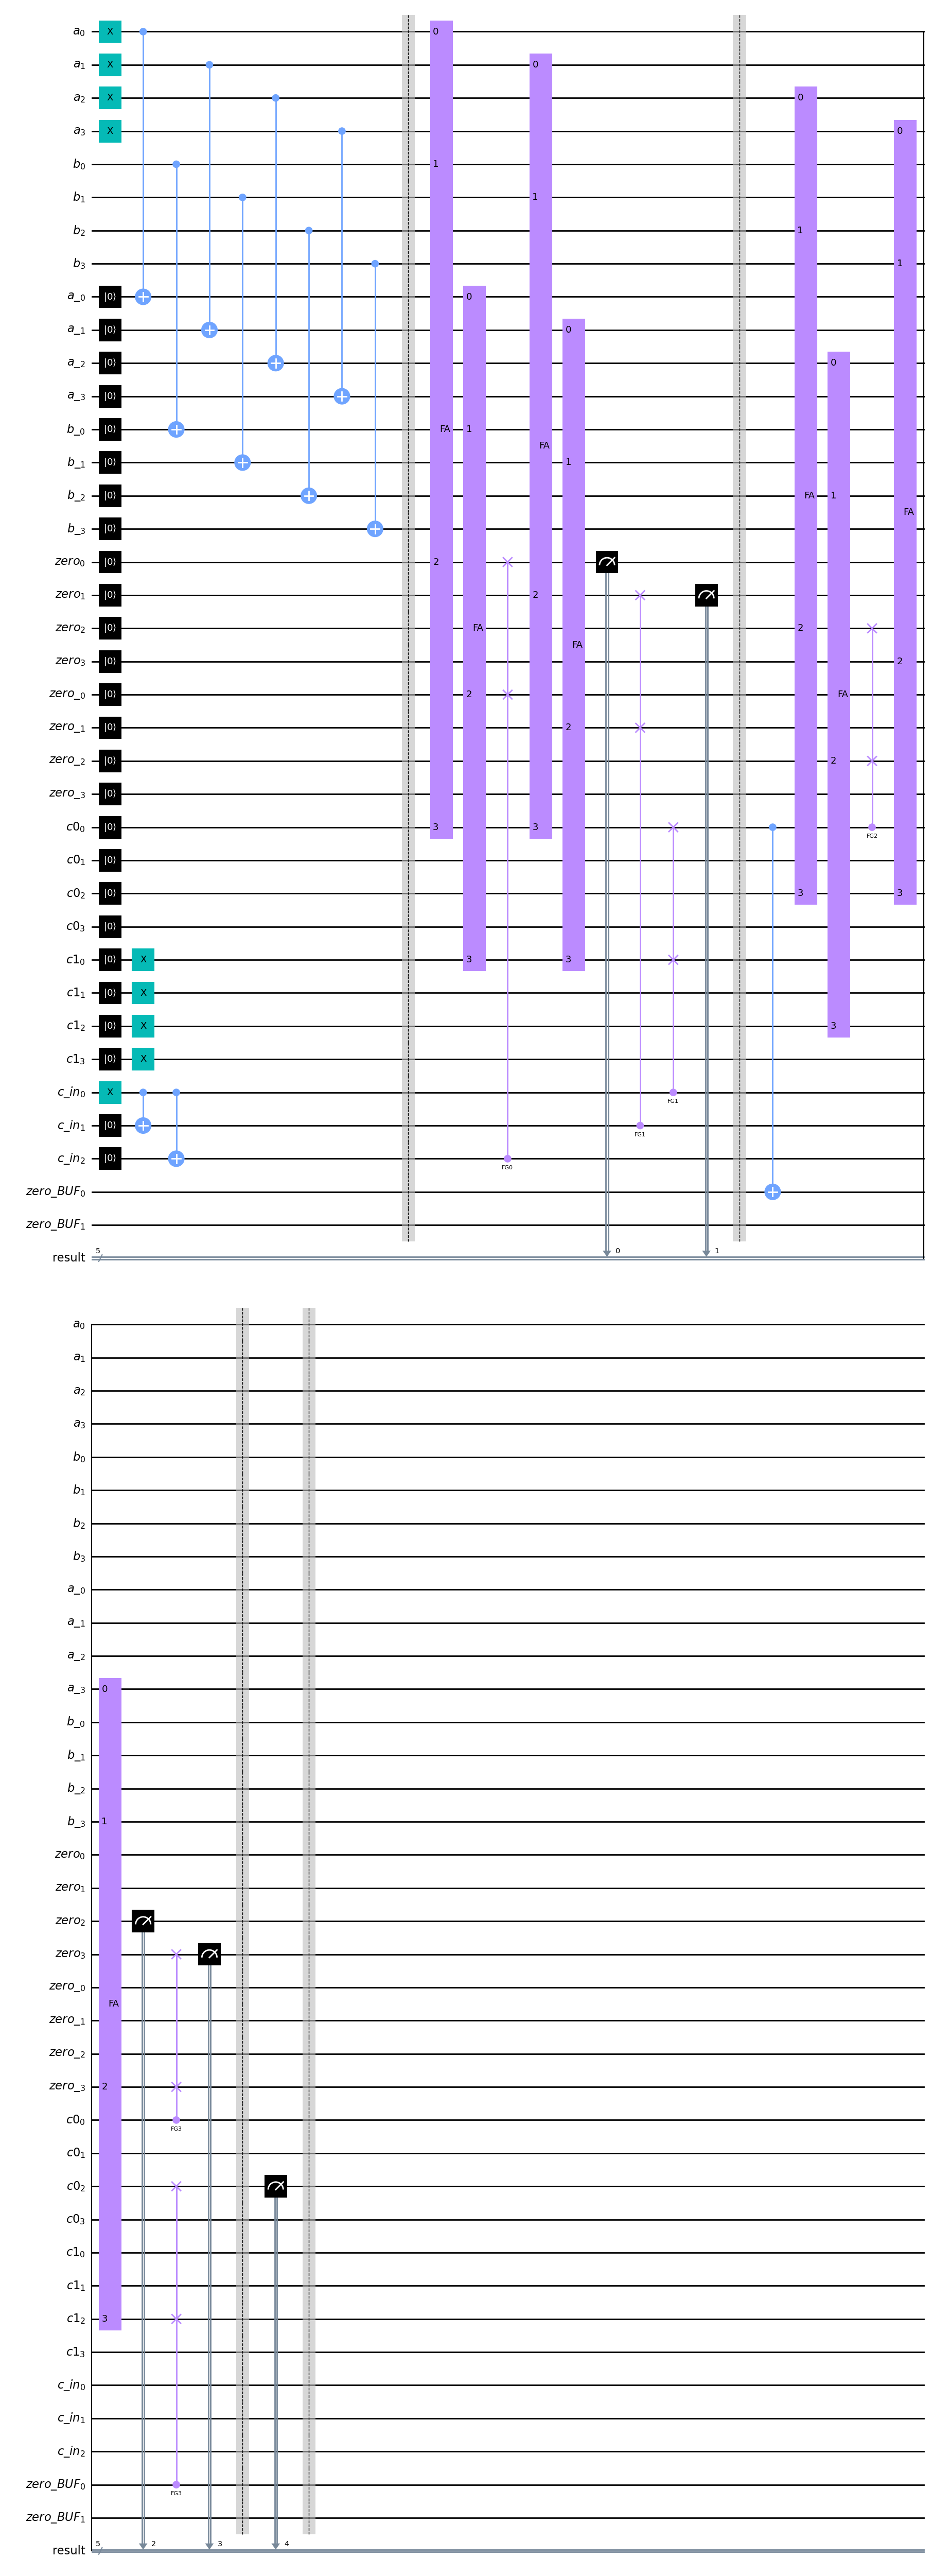

In [500]:
# NB: use n s.t. (n % 2 == 0)
n = 4
a = '1' * n
b = '0' * n
RCSA = circuit_RCSA_v1_old(n, a, b, '1')
RCSA.draw(output="mpl", vertical_compression="high")

In [440]:
check_correctness(4,'0', circuit_RCSA_v1)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
abc 	 c s
-------------
0000+0000+0 	 0 0000
0000+0001+0 	 0 0001
0000+0010+0 	 0 0010
0000+0011+0 	 0 0011
0000+0100+0 	 0 0100
0000+0101+0 	 0 0101
0000+0110+0 	 0 0110
0000+0111+0 	 0 0111
0000+1000+0 	 0 1000
0000+1001+0 	 0 1001
0000+1010+0 	 0 1010
0000+1011+0 	 0 1011
0000+1100+0 	 0 1100
0000+1101+0 	 0 1101
0000+1110+0 	 0 1110
0000+1111+0 	 0 1111
0001+0000+0 	 0 0001
0001+0001+0 	 0 0010
0001+0010+0 	 0 0011
0001+0011+0 	 0 0100
0001+0100+0 	 0 0101
0001+0101+0 	 0 0110
0001+0110+0 	 0 0111
0001+0111+0 	 0 1000
0001+1000+0 	 0 1001
0001+1001+0 	 0 1010
0001+1010+0 	 0 1011
0001+1011+0 	 0 1100
0001+1100+0 	 0 1101
0001+1101+0 	 0 1110
0001+1110+0 	 0 1111
0001+1111+0 	 1 0000
0010+0000+0 	 0 0010
0010+0001+0 	 0 0011
0010+0010+0 	 0 0100
0010+0011+0 	 0 0101
0010+0100+0 	 0 0110
0010+0101+0 	 0 0111
0010+0110+0 	 0 1000
0010+0111+0 	 0 1001
0010+10

## RCSA - design 1 - v2: 2 submodules of 4 bits RFA adder

In [529]:
def circuit_RCSA_v2(n: int, a_inp:str, b_inp:str, c_inp:str) -> QuantumCircuit:
    """Implements a circuit for an n-bit RCSA.

    It works, but there's redundancy in the code. There's a version with less lines,
    but the readability is not as good as this version.

    Parameters
    ----------


    Returns
    -------
    """

    name = "RCSA design 1"

    a_inp = a_inp[::-1] # read from LSB to MSB
    b_inp = b_inp[::-1]


    qc_rcsa = QuantumCircuit()


    a = QuantumRegister(n, name='a')
    b = QuantumRegister(n, name='b')
    a_ = QuantumRegister(n, name='a_')
    b_ = QuantumRegister(n, name='b_')

    c0 = QuantumRegister(n, name='c0') # THEY CAN BE HALVED, since the second couple of RFA do not take in input a fixed 0/1
    c1 = QuantumRegister(n, name='c1') # THEY CAN BE HALVED, ...

    zero = QuantumRegister(n, name='zero')   # can be renamed zero0, as in c0 and c1
    zero_ = QuantumRegister(n, name='zero_') # can be renamed zero1
    
    c_in = QuantumRegister(6, name='c_in')   # they can probably be reduced to just 1 qubit

    zero_BUF = QuantumRegister(n/2, name='zero_BUF') # n is guaranteed to be even

    result = ClassicalRegister(n+1, name='result')

    qc_rcsa = QuantumCircuit(a, b, a_, b_, zero, zero_, c0, c1, c_in, zero_BUF, result)

    # encode the input
    if c_inp == '1':
        qc_rcsa.x(c_in[0])
    
    qc_rcsa.reset(c_in[1])
    qc_rcsa.reset(c_in[2])
    qc_rcsa.reset(c_in[3])
    qc_rcsa.reset(c_in[4])
    qc_rcsa.reset(c_in[5])

    qc_rcsa.cx(c_in[0], c_in[1]) # copy the c_in
    qc_rcsa.cx(c_in[0], c_in[2]) # copy the c_in
    qc_rcsa.cx(c_in[0], c_in[3]) # copy the c_in
    qc_rcsa.cx(c_in[0], c_in[4]) # copy the c_in
    qc_rcsa.cx(c_in[0], c_in[5]) # copy the c_in

    for i in range(n):
        if a_inp[i] == '1':
            qc_rcsa.x(a[i])
        if b_inp[i] == '1':
            qc_rcsa.x(b[i])
        qc_rcsa.reset(a_[i])
        qc_rcsa.reset(b_[i])
        qc_rcsa.cx(a[i], a_[i])
        qc_rcsa.cx(b[i], b_[i])
        qc_rcsa.reset(c0[i])
        qc_rcsa.reset(c1[i])
        qc_rcsa.x(c1[i])
        qc_rcsa.reset(zero[i])
        qc_rcsa.reset(zero_[i])

    qc_rcsa.barrier()
    



    # perform the operations
    for i in range(n):
        if i > 3: # No more in the first stage -> use c0 instead of c_in
            if i % 4 == 0:
                qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i//4]]) # i//n gives the stage I'am in
                qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i//4]])
                qc_rcsa.cswap(c0[0], zero[i], zero_[i])
                qc_rcsa.barrier()
                qc_rcsa.measure(zero[i], result[i]) # s
                
            elif (i % 4) > 0 and (i % 4) < 3:
                qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i//4]])
                qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i//4]])
                qc_rcsa.cswap(c0[0], zero[i], zero_[i])
                qc_rcsa.barrier()
                qc_rcsa.measure(zero[i], result[i]) # s,s
  
            else:
                qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i//4]])
                qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i//4]])
                qc_rcsa.cswap(c0[0], zero[i], zero_[i])
                qc_rcsa.measure(zero[i], result[i]) # s
                qc_rcsa.barrier()

                qc_rcsa.cswap(zero_BUF[(i//4)-1], c0[i//4], c1[i//4])

                if i == (n-1): # measure c_out
                    qc_rcsa.measure(c0[i//4], result[i+1])
                else:
                    qc_rcsa.cx(c0[0], zero_BUF[floor(i/4)])
                


        else: # I'm in th first stage
            if i == 0:
                qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[i]])
                qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[i]])
                qc_rcsa.cswap(c_in[4-i], zero[i], zero_[i])
                qc_rcsa.barrier()
                qc_rcsa.measure(zero[i], result[i]) # s0
                
            elif i > 0 and i < 3:
                qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[0]])
                qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[0]])
                qc_rcsa.cswap(c_in[4-i], zero[i], zero_[i])
                qc_rcsa.barrier()
                qc_rcsa.measure(zero[i], result[i]) # s1,s2
  
            else:
                qc_rcsa.append(FA, [a[i], b[i], zero[i], c0[0]])
                qc_rcsa.append(FA, [a_[i], b_[i], zero_[i], c1[0]])
                qc_rcsa.cswap(c_in[4-i], zero[i], zero_[i])
                qc_rcsa.measure(zero[i], result[i]) # s3
                qc_rcsa.barrier()

                qc_rcsa.cswap(c_in[4-i-1], c0[0], c1[0])

                if n == 4: # measure c_out
                    qc_rcsa.measure(c0[0], result[i+1])
                else:
                    qc_rcsa.cx(c0[0], zero_BUF[floor(i/4)])
                    qc_rcsa.barrier()




    return qc_rcsa

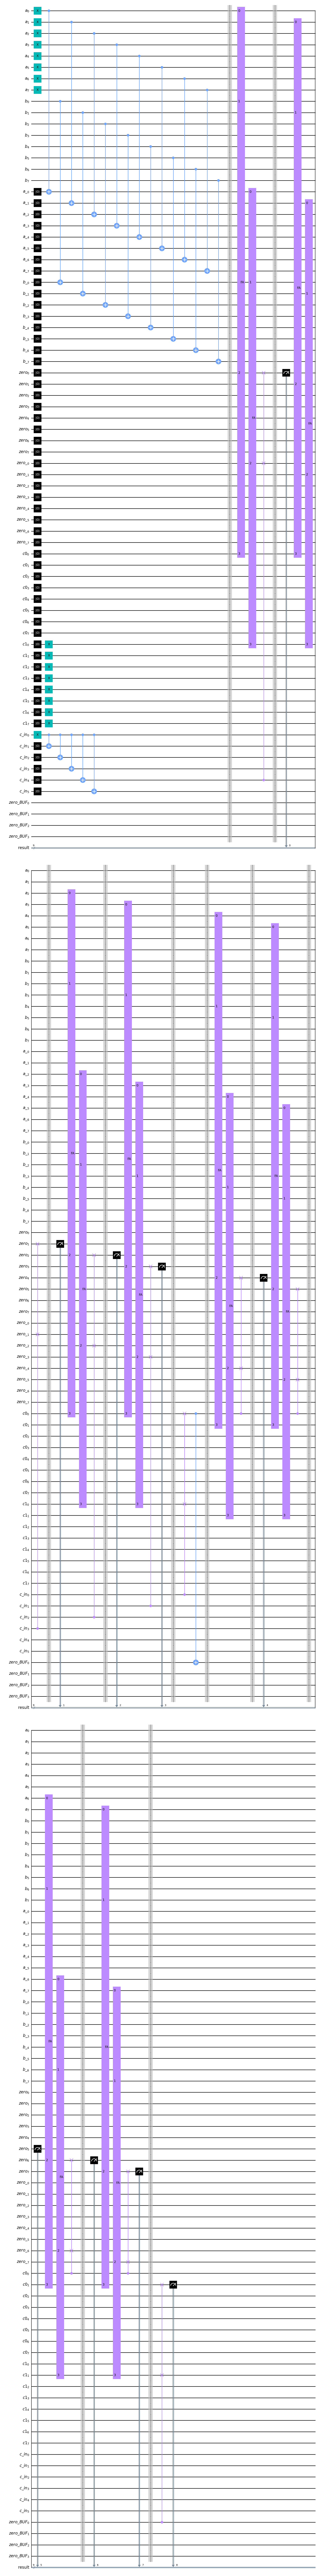

In [530]:
# NB: use n s.t. (n % 2 == 0)
n = 8
a = '1' * n
b = '0' * n
RCSA = circuit_RCSA_v2(n, a, b, '1')
RCSA.draw(output="mpl", vertical_compression="high")

In [532]:
n = 8
check_correctness(n,'0', circuit_RCSA_v2, getRandomInputs=True)

['00000000', '00000001', '00000010', '00000011', '00000100', '00000101', '00000110', '00000111', '00001000', '00001001', '00001010', '00001011', '00001100', '00001101', '00001110', '00001111', '00010000', '00010001', '00010010', '00010011', '00010100', '00010101', '00010110', '00010111', '00011000', '00011001', '00011010', '00011011', '00011100', '00011101', '00011110', '00011111', '00100000', '00100001', '00100010', '00100011', '00100100', '00100101', '00100110', '00100111', '00101000', '00101001', '00101010', '00101011', '00101100', '00101101', '00101110', '00101111', '00110000', '00110001', '00110010', '00110011', '00110100', '00110101', '00110110', '00110111', '00111000', '00111001', '00111010', '00111011', '00111100', '00111101', '00111110', '00111111', '01000000', '01000001', '01000010', '01000011', '01000100', '01000101', '01000110', '01000111', '01001000', '01001001', '01001010', '01001011', '01001100', '01001101', '01001110', '01001111', '01010000', '01010001', '01010010', '01

### Evaluation: v2